In [1]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm
from scipy.integrate import quad
import pandas as pd

# simulate

In [2]:
N_sim = int(50e3)
dt = 1e-4
dB = np.sqrt(dt)

V_A_old = 0.4
V_A_new = 0.8
a_old = 2
a_new = 1.5

t_LED = 1

RT_all_sim = np.zeros((N_sim))


In [3]:
def simulate_single_bound_V_A_change(V_A_old, V_A_new, a_old, a_new, t_LED, dt):
    t = 0
    DV = 0

    while True:
        if t >= t_LED:
            v = V_A_new
            a = a_new
        else:
            v = V_A_old
            a = a_old
        
        t += dt
        DV += v*dt + np.random.normal(0, dB)
        
        if DV >= a:
            return t
        

sim_results = Parallel(n_jobs=-1)(delayed(simulate_single_bound_V_A_change)\
                                  (V_A_old, V_A_new, a_old, a_new, t_LED, dt) for _ in tqdm(range(N_sim)))

100%|██████████| 50000/50000 [00:36<00:00, 1352.47it/s]


# pdf

In [ ]:
def rho_A_t_fn(t, V_A, theta_A):
    """
    For AI,prob density of t given V_A, theta_A
    """
    if t <= 0:
        return 0
    return (theta_A*1/np.sqrt(2*np.pi*(t)**3))*np.exp(-0.5 * (V_A**2) * (((t) - (theta_A/V_A))**2)/(t))


def P_t_x(x, t, v, a):
    """
    Prob that DV = x at time t given v, a 
    """
    return (1/np.sqrt(2 * (np.pi) * t)) * \
        ( np.exp(-((x - v*t)**2)/(2*t)) - np.exp( 2*v*a - ((x - 2*a - v*t)**2)/(2*t) ) )


def P_old_at_x_times_P_new_hit(x, t, V_A_old, V_A_new, a_old, a_new, t_LED):
    """
    Prob that DV is at x at t_LED and new V_A hits "a-x" bound at t - t_LED
    t is surely > t_LED
    """
    if x <= a_new:
        return P_t_x(x, t_LED, V_A_old, a_old) * rho_A_t_fn(t-t_LED, V_A_new, a_new - x)
    else:
        return 0  



def PDF_hit_V_A_change(t, V_A_old, V_A_new, a_old, a_new, t_LED):
    """
    PDF of RT of hitting single bound with V_A change at t_LED
    """
    if t < t_LED:
        p = rho_A_t_fn(t, V_A_old, a_old)
    elif t == t_LED:
        p = quad(P_t_x, a_new, a_old, args=(t_LED, V_A_old, a_old))[0]
    else:
        p = quad(P_old_at_x_times_P_new_hit, -np.inf, a_new, args=(t, V_A_old, V_A_new, a_old, a_new, t_LED))[0]    
    
    return p

In [37]:
quad(PDF_hit_V_A_change, 0, np.inf, args=(V_A_old, V_A_new, a_old, a_new, t_LED))[0], quad(P_t_x, a_new, a_old, args=(t_LED, V_A_old, a_old))[0]

(0.9504944582261469, 0.049505541786826056)

In [49]:
quad(P_t_x, a_new, a_old, args=(t_LED, V_A_old, a_old))[0], np.diff(bins)[0], quad(P_t_x, a_new, a_old, args=(t_LED, V_A_old, a_old))[0]/np.diff(bins)[0]

(0.049505541786826056,
 np.float64(0.1515050505050505),
 np.float64(0.32675835968369754))

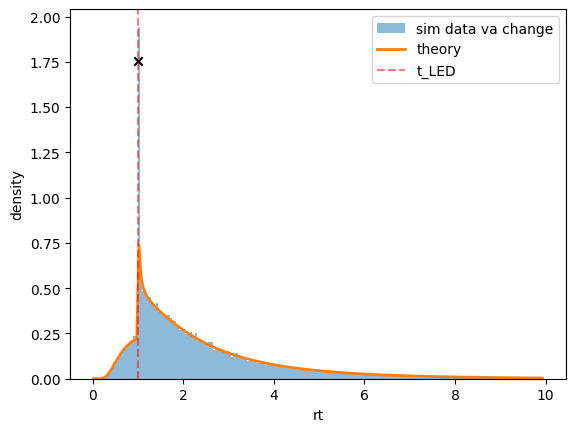

In [82]:
# data
# bins = np.linspace(0.001, 10, 100)
bin_width = 0.05
bins = np.arange(0, 10, bin_width)
plt.hist(sim_results, bins=bins, density=True, alpha=0.5, label='sim data va change');

# theory
t_pts = bins[:-1] + bin_width/2
theory_pdf = np.array([PDF_hit_V_A_change(t, V_A_old, V_A_new, a_old, a_new, t_LED) for t in t_pts])
plt.plot(t_pts, theory_pdf, label='theory', lw=2)
plt.axvline(x=t_LED, color='red', linestyle='--', label='t_LED', alpha=0.5)
plt.scatter(t_LED,  rho_A_t_fn(t_LED, V_A_old, V_A_new) + rho_A_t_fn(t_LED, V_A_new, a_new) + PDF_hit_V_A_change(t_LED, V_A_old, V_A_new, a_old, a_new, t_LED)/bin_width, color='k', marker='x')
plt.xlabel('rt')
plt.ylabel('density')
plt.legend();


In [77]:
0.05/bin_width

1.0

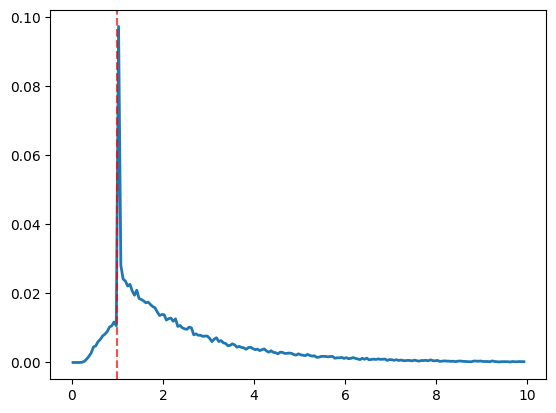

In [79]:

sim_hist = np.histogram(sim_results, bins=bins, density=True)[0]
sim_hist *= bin_width
t_pts = bins[:-1] + np.diff(bins)/2
plt.plot(t_pts, sim_hist, label='sim hist', lw=2)
plt.axvline(x=t_LED, color='red', linestyle='--', label='t_LED', alpha=0.7)